In [32]:
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.integrate import simps
from sklearn.metrics import roc_auc_score
import pickle

In [2]:
# plot data of a single channel
def plot_channel_feature(ax, channel_data, ylabel):
    ax.plot(channel_data)
    ax.set(xlabel="Time/s", ylabel=ylabel)


In [3]:
# plot all features of a channel
# note that the last window tends
# to be corrupted so it is removed
def plot_channel_all_features(channel, signal,
                      linelength, energy,
                      var, beta):
    fig, axes = plt.subplots(nrows=5, ncols=1,
                             figsize=(20, 15))

    plot_channel_feature(axes[0], signal[:-1, channel],
                         'Intensity')
    plot_channel_feature(axes[1], linelength[:-1, channel],
                         'Line-length')
    plot_channel_feature(axes[2], energy[:-1, channel],
                         'Energy')
    plot_channel_feature(axes[3], var[:-1, channel],
                         'Variance')
    plot_channel_feature(axes[4], beta[:-1, channel],
                         'Spectral power of Beta band')
    # plot_channel_feature(axes[5], hfo[:-1, channel],
    #                      'Spectral power of HFO band')

    
    axes[0].set_title('Channel ' + str(channel+1))
    plt.tight_layout()
    plt.show()
    fig.savefig('channel_' + str(channel+1) + '.eps')

In [4]:
def compute_signal_by_window(data, num_windows, num_channels):
    signal_by_window = np.empty((num_windows, num_channels),
                                dtype=np.float64)

    for w in range(num_windows-1):
        min_timepoint = w*SAMPLING_FREQ
        max_timepoint = (w+1)*SAMPLING_FREQ
        signal_by_window[w, :] = np.mean(\
            data[min_timepoint:max_timepoint, :], axis=0)
    return signal_by_window
    

# Line length

In [5]:
# Compute average line-length within a window
def compute_mean_line_length(data):
    unshifted_data = data[:-1]
    shifted_data = data[1:]
    
    tmp = np.mean(np.absolute(
        unshifted_data - shifted_data), axis=0)
    
    return np.mean(np.absolute(
        unshifted_data - shifted_data), axis=0)


In [6]:
# iterate through each window and compute average
# line-length for every channel
def compute_line_length_by_window(data, num_windows, num_channels):
    line_length_by_window = np.empty((num_windows, num_channels),
                                     dtype=np.float64)

    for w in range(num_windows-1):
        min_timepoint = w*SAMPLING_FREQ
        max_timepoint = (w+1)*SAMPLING_FREQ
        line_length_by_window[w, :] = compute_mean_line_length(
            data[min_timepoint:max_timepoint, :])
    return line_length_by_window


# Energy

In [7]:
# compute average energy per window
def compute_energy(data, num_windows, num_channels):
    return np.mean(np.square(data), axis=0)


In [8]:
def compute_energy_by_window(data, num_windows, num_channels):
    energy_by_window = np.empty((num_windows, num_channels),
                                dtype=np.float64)

    # iterate through each window and compute average
    # energy for every channel
    for w in range(num_windows-1):
        min_timepoint = w*SAMPLING_FREQ
        max_timepoint = (w+1)*SAMPLING_FREQ
        energy_by_window[w, :] = compute_energy(
            data[min_timepoint:max_timepoint, :],
            num_windows, num_channels)
        
    return energy_by_window

# Variance

In [9]:
def compute_var_by_window(data, num_windows, num_channels):
    var_by_window = np.empty((num_windows, num_channels),
                             dtype=np.float64)

    # iterate through each window and compute
    # variance for every channel
    for w in range(num_windows-1):
        min_timepoint = w*SAMPLING_FREQ
        max_timepoint = (w+1)*SAMPLING_FREQ
        var_by_window[w, :] = np.var(
            data[min_timepoint:max_timepoint, :])
    
    return var_by_window


# Spectral power

In [10]:
# compute spectral power within
# a frequency band.
#   - data: timeseries
#   - min_band_freq: lower limit of the frequency band
#   - max_band_freq: upper limit of the frequency band

def spectral_power_by_band(data,
                           sf,
                           min_band_freq,
                           max_band_freq):
    # estimate power spectral density using Welch’s method
    freqs, psd = signal.welch(data, sf, nperseg=sf/2)
    freq_res = freqs[1] - freqs[0] # frequency resolution
    
    # logical array defining the frequency band
    logical_ind = np.logical_and(freqs >= min_band_freq,
                                 freqs <= max_band_freq)
    # estimate the spectral power by approximating
    # the area under the power spectral density
    # curve within the frequency band
    return simps(psd[logical_ind], dx=freq_res)


In [11]:
def compute_beta_power_by_window(data, num_windows, num_channels, sf):
    beta_power_by_window = np.empty((num_windows, num_channels),
                                    dtype=np.float64)
    for c in range(num_channels):
        for w in range(num_windows-1):
            min_timepoint = w*sf
            max_timepoint = (w+1)*sf

            # beta band: 12 - 30Hz
            beta_power_by_window[w, c] = spectral_power_by_band(
                data[min_timepoint:max_timepoint, c], sf, 12, 30)
    return beta_power_by_window


In [12]:
def compute_hfo_power_by_window(data, num_windows, num_channels):
    hfo_power_by_window = np.empty((num_windows, num_channels),
                                   dtype=np.float64)

    for c in range(num_channels):
        for w in range(num_windows-1):
            min_timepoint = w*SAMPLING_FREQ
            max_timepoint = (w+1)*SAMPLING_FREQ

            # HFO band: 100 - 600 Hz
            hfo_power_by_window[w, c] = spectral_power_by_band(
                data[min_timepoint:max_timepoint, c], 100, 600)
    return hfo_power_by_window     
    

In [13]:
def fullspectral_power(data, sf):
    # estimate power spectral density using Welch’s method
    freqs, psd = signal.welch(data, sf, nperseg=sf/2)
    freq_res = freqs[1] - freqs[0] # frequency resolution
    
    return simps(psd, dx=freq_res)


def compute_fullspectrum_by_window(data, num_windows, num_channels, sf):
    power_by_window = np.empty((num_windows, num_channels),
                                    dtype=np.float64)
    for c in range(num_channels):
        for w in range(num_windows-1):
            min_timepoint = w*SAMPLING_FREQ
            max_timepoint = (w+1)*SAMPLING_FREQ

            power_by_window[w, c] = fullspectral_power(
                data[min_timepoint:max_timepoint, c], sf)
    return power_by_window


# Results

In [40]:
data_dir = '/home/ghn8/courses/neuroengineering/project/data'
patient_id = 1
sample_id = 100

ictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/ictal train/' % patient_id
nonictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/non-ictal train/' % patient_id
sample_name = 'patient_%d_%d.mat' % (patient_id, sample_id)
ictal_data_file = os.path.join(ictal_sample_dir, sample_name)
nonictal_data_file = os.path.join(nonictal_sample_dir, sample_name)

# load data
ictal_data_mat = sio.loadmat(ictal_data_file)
ictal_data = ictal_data_mat['data'].astype(np.float32)


nonictal_data_mat = sio.loadmat(nonictal_data_file)
nonictal_data = nonictal_data_mat['data'].astype(np.float32)


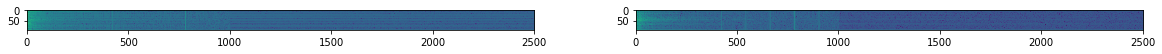

In [41]:
def fft(timeseries):
    return np.log10(np.absolute(np.fft.rfft(timeseries)))

ictal_spectrum = fft(ictal_data.T)
nonictal_spectrum = fft(nonictal_data.T)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

axes[0].imshow(ictal_spectrum)
axes[1].imshow(nonictal_spectrum)


/nfs01/shared_software/anaconda3/envs/gia/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


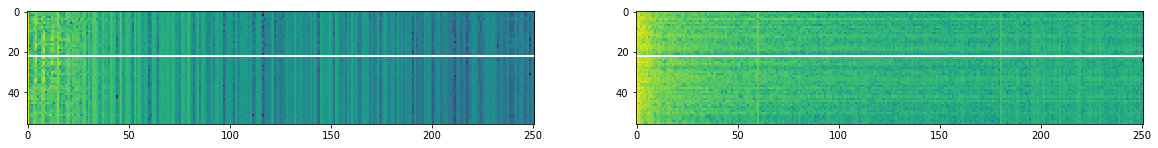

In [42]:
patient_id = 2
sample_id = 100

ictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/ictal train/' % patient_id
nonictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/non-ictal train/' % patient_id
sample_name = 'patient_%d_%d.mat' % (patient_id, sample_id)
ictal_data_file = os.path.join(ictal_sample_dir, sample_name)
nonictal_data_file = os.path.join(nonictal_sample_dir, sample_name)

# load data
ictal_data_mat = sio.loadmat(ictal_data_file)
ictal_data = ictal_data_mat['data'].astype(np.float32)


nonictal_data_mat = sio.loadmat(nonictal_data_file)
nonictal_data = nonictal_data_mat['data'].astype(np.float32)

ictal_spectrum = fft(ictal_data.T)
nonictal_spectrum = fft(nonictal_data.T)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

axes[0].imshow(ictal_spectrum)
axes[1].imshow(nonictal_spectrum)


/nfs01/shared_software/anaconda3/envs/gia/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


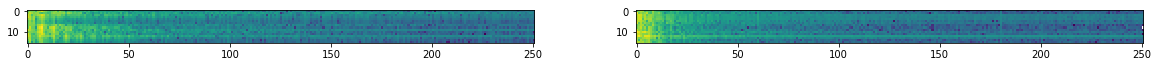

In [43]:
patient_id = 3
sample_id = 100

ictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/ictal train/' % patient_id
nonictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/non-ictal train/' % patient_id
sample_name = 'patient_%d_%d.mat' % (patient_id, sample_id)
ictal_data_file = os.path.join(ictal_sample_dir, sample_name)
nonictal_data_file = os.path.join(nonictal_sample_dir, sample_name)

# load data
ictal_data_mat = sio.loadmat(ictal_data_file)
ictal_data = ictal_data_mat['data'].astype(np.float32)


nonictal_data_mat = sio.loadmat(nonictal_data_file)
nonictal_data = nonictal_data_mat['data'].astype(np.float32)

ictal_spectrum = fft(ictal_data.T)
nonictal_spectrum = fft(nonictal_data.T)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

axes[0].imshow(ictal_spectrum)
axes[1].imshow(nonictal_spectrum)


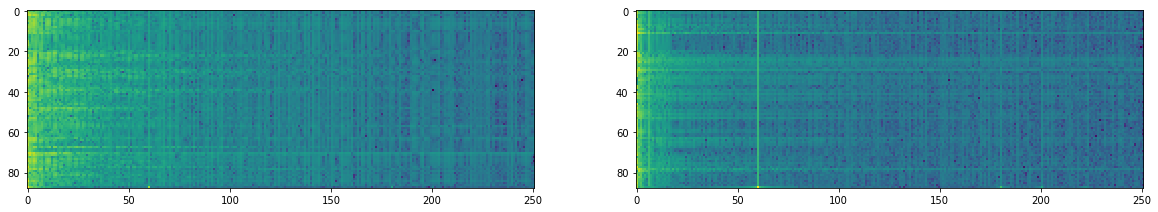

In [44]:
patient_id = 4
sample_id = 100

ictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/ictal train/' % patient_id
nonictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/non-ictal train/' % patient_id
sample_name = 'patient_%d_%d.mat' % (patient_id, sample_id)
ictal_data_file = os.path.join(ictal_sample_dir, sample_name)
nonictal_data_file = os.path.join(nonictal_sample_dir, sample_name)

# load data
ictal_data_mat = sio.loadmat(ictal_data_file)
ictal_data = ictal_data_mat['data'].astype(np.float32)


nonictal_data_mat = sio.loadmat(nonictal_data_file)
nonictal_data = nonictal_data_mat['data'].astype(np.float32)

ictal_spectrum = fft(ictal_data.T)
nonictal_spectrum = fft(nonictal_data.T)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

axes[0].imshow(ictal_spectrum)
axes[1].imshow(nonictal_spectrum)


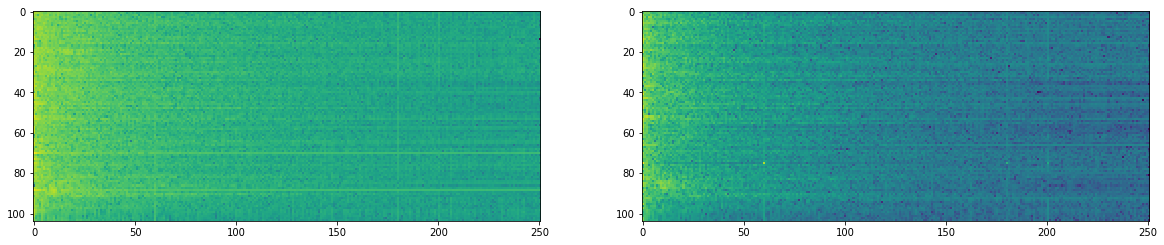

In [45]:
patient_id = 5
sample_id = 100

ictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/ictal train/' % patient_id
nonictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/non-ictal train/' % patient_id
sample_name = 'patient_%d_%d.mat' % (patient_id, sample_id)
ictal_data_file = os.path.join(ictal_sample_dir, sample_name)
nonictal_data_file = os.path.join(nonictal_sample_dir, sample_name)

# load data
ictal_data_mat = sio.loadmat(ictal_data_file)
ictal_data = ictal_data_mat['data'].astype(np.float32)


nonictal_data_mat = sio.loadmat(nonictal_data_file)
nonictal_data = nonictal_data_mat['data'].astype(np.float32)

ictal_spectrum = fft(ictal_data.T)
nonictal_spectrum = fft(nonictal_data.T)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

axes[0].imshow(ictal_spectrum)
axes[1].imshow(nonictal_spectrum)


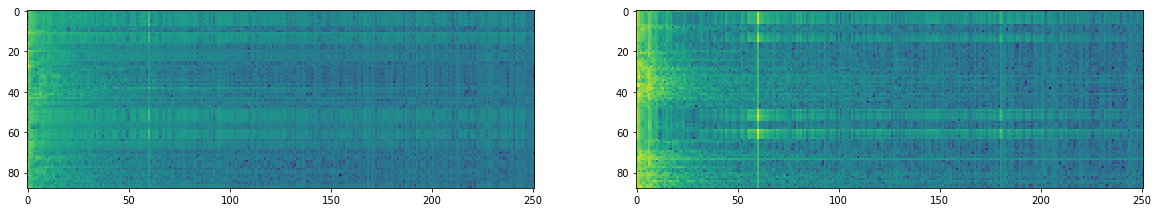

In [46]:
patient_id = 6
sample_id = 100

ictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/ictal train/' % patient_id
nonictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/non-ictal train/' % patient_id
sample_name = 'patient_%d_%d.mat' % (patient_id, sample_id)
ictal_data_file = os.path.join(ictal_sample_dir, sample_name)
nonictal_data_file = os.path.join(nonictal_sample_dir, sample_name)

# load data
ictal_data_mat = sio.loadmat(ictal_data_file)
ictal_data = ictal_data_mat['data'].astype(np.float32)


nonictal_data_mat = sio.loadmat(nonictal_data_file)
nonictal_data = nonictal_data_mat['data'].astype(np.float32)

ictal_spectrum = fft(ictal_data.T)
nonictal_spectrum = fft(nonictal_data.T)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

axes[0].imshow(ictal_spectrum)
axes[1].imshow(nonictal_spectrum)


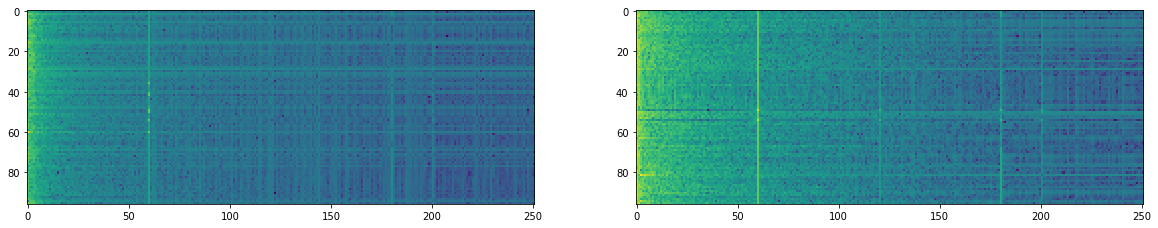

In [47]:
patient_id = 7
sample_id = 100

ictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/ictal train/' % patient_id
nonictal_sample_dir = '/home/ghn8/courses/neuroengineering/project/data/patient_%d/non-ictal train/' % patient_id
sample_name = 'patient_%d_%d.mat' % (patient_id, sample_id)
ictal_data_file = os.path.join(ictal_sample_dir, sample_name)
nonictal_data_file = os.path.join(nonictal_sample_dir, sample_name)

# load data
ictal_data_mat = sio.loadmat(ictal_data_file)
ictal_data = ictal_data_mat['data'].astype(np.float32)


nonictal_data_mat = sio.loadmat(nonictal_data_file)
nonictal_data = nonictal_data_mat['data'].astype(np.float32)

ictal_spectrum = fft(ictal_data.T)
nonictal_spectrum = fft(nonictal_data.T)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

axes[0].imshow(ictal_spectrum)
axes[1].imshow(nonictal_spectrum)
